# Motorcycle Night Ride
- Motorcycle Night Ride (Semantic Segmentation) 데이터셋 [링크](https://www.kaggle.com/datasets/sadhliroomyprime/motorcycle-night-ride-semantic-segmentation/)
- U-Net 모델 + a

## 목차


## 0. Set up

In [1]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#!pip install pycocotools
from pycocotools.coco import COCO
import skimage.io as io
import random
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
# GPU 연결 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5694441116104382126
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14476378112
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11744778046778169796
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [5]:
# Load dataset
wd_path = '/aiffel/aiffel/workplace/main_quest/main_quest_2/' # working directory path

img_dir = os.path.join(wd_path, 'data/Motorcycle_Night_Ride_Dataset/images')
annotation_file = os.path.join(wd_path, 'data/Motorcycle_Night_Ride_Dataset/COCO_motorcycle (pixel).json')

# initialize the COCO api for instance annotations
coco=COCO(annotation_file)
#data = COCOParser(annotation_file, img_dir)

loading annotations into memory...
Done (t=5.36s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

6 COCO categories: 
Rider My bike Moveable Lane Mark Road Undrivable



In [7]:
# Observe how the ids range from 0 to 6
cats

[{'id': 1329681,
  'name': 'Rider',
  'supercategory': 'Rider',
  'isthing': 1,
  'color': [17, 74, 20]},
 {'id': 1323885,
  'name': 'My bike',
  'supercategory': 'My bike',
  'isthing': 1,
  'color': [109, 51, 20]},
 {'id': 1323884,
  'name': 'Moveable',
  'supercategory': 'Moveable',
  'isthing': 1,
  'color': [108, 51, 20]},
 {'id': 1323882,
  'name': 'Lane Mark',
  'supercategory': 'Lane Mark',
  'isthing': 1,
  'color': [106, 51, 20]},
 {'id': 1323881,
  'name': 'Road',
  'supercategory': 'Road',
  'isthing': 1,
  'color': [105, 51, 20]},
 {'id': 1323880,
  'name': 'Undrivable',
  'supercategory': 'Undrivable',
  'isthing': 1,
  'color': [104, 51, 20]}]

In [46]:
# input image와 target image 리스트 만들기
img_list = os.listdir(img_dir)
input_img_list = sorted([os.path.join(img_dir, file) for file in img_list if file.endswith(").png")])
target_img_list = sorted([os.path.join(img_dir, file) for file in img_list if file.endswith(".png___fuse.png")])

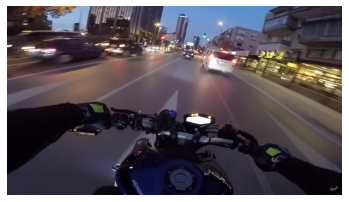

In [47]:
# sample image와 target image 확인
ex_num = 10
ex_img_input = input_img_list[ex_num]
ex_img_target = target_img_list[ex_num]

from tensorflow.keras.utils import load_img, img_to_array

# raw image (sample)
plt.axis("off")
plt.imshow(load_img(ex_img_input))

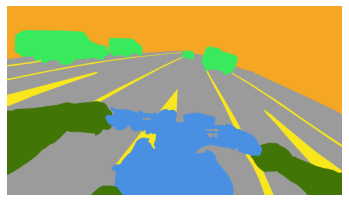

In [48]:
# target image(target segment)
plt.axis("off")
plt.imshow(load_img(ex_img_target))

## 1. Data Preprocessing

In [91]:
img_size = (272,480) # original: (1080, 1920)
num_imgs = len(input_img_list)

random.Random(1234).shuffle(input_img_list)
random.Random(1234).shuffle(target_img_list)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in tqdm(range(num_imgs)):
    input_imgs[i] = path_to_input_image(input_img_list[i])
    targets[i] = path_to_target(target_img_list[i])

100%|██████████| 198/198 [00:24<00:00,  8.20it/s]


In [92]:
num_val_samples = 50
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [28]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (320, 180), method="nearest")
    input_mask = tf.image.resize(input_mask, (320, 180), method="nearest")

    return input_image, input_mask 

In [29]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [27]:
# def normalize(input_image, input_mask):
#     input_image = tf.cast(input_image, tf.float32) / 255.0
#     input_mask -= 1
  
#     return input_image, input_mask

In [30]:
def load_image_train(sample, target):
    input_image = sample
    input_mask = target
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [31]:
def load_image_val(sample, target):
    input_image = sample
    input_mask = target
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

### Data Visualization

In [58]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

ValueError: Expected image array to have rank 3 (single image). Got array with shape: (198, 180, 320, 3)

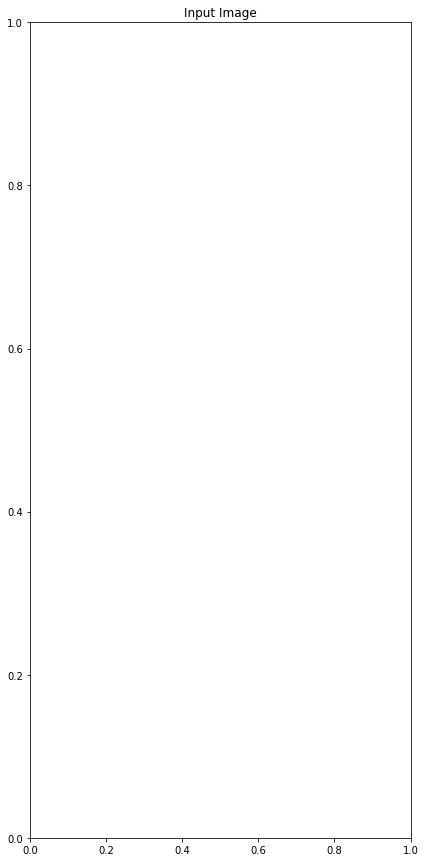

In [62]:
display([input_imgs, targets])

In [ ]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## 2. Model Building (U-Net)
![u-net]('./unet.jpeg')

In [93]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Taking a batch of test inputs to measure model's progress.
#test_images, test_masks = next(iter(resized_val_ds))

In [94]:
model = get_model(img_size=img_size, num_classes=6)

In [95]:
print(train_input_imgs[1].shape)
print(val_input_imgs[1].shape)
print(train_targets[1].shape)
print(val_targets[1].shape)

(272, 480, 3)
(272, 480, 3)
(272, 480, 1)
(272, 480, 1)


In [96]:
LEARNING_RATE = 0.001
EPOCHS = 10

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("u-net.keras",
                                   save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_input_imgs, train_targets,
    epochs=EPOCHS,
    validation_data=(val_input_imgs, val_targets),
    callbacks=callbacks,
)

Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[32,256,17,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_1/conv2d_transpose_15/conv2d_transpose (defined at tmp/ipykernel_546/1083047866.py:16) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_9936]

Function call stack:
train_function


In [ ]:

model_history = unet_model.fit(train_input_imgs, train_targets,
                               epochs=NUM_EPOCHS,
                               callbacks=callbacks,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=validation_batches
                              validation_data=(val_input_imgs, val_targets)
                              )

In [77]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [78]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    # p = layers.Dropout(0.3)(p)

    return f, p

In [79]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    #x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [66]:
print(img_size + (3,))

(180, 320, 3)


In [67]:
    # inputs
    inputs = keras.Input(shape=img_size + (3,))
    
    # rescaling
    normalized_inputs = layers.Rescaling(1./255)(inputs) # 입력 이미지의 범위 [0-1]

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(normalized_inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

In [73]:
bottleneck

<KerasTensor: shape=(None, 11, 20, 1024) dtype=float32 (created by layer 'conv2d_9')>

In [74]:
p4

<KerasTensor: shape=(None, 11, 20, 512) dtype=float32 (created by layer 'dropout_3')>

In [75]:
f4

<KerasTensor: shape=(None, 22, 40, 512) dtype=float32 (created by layer 'conv2d_7')>

In [76]:
upsample_block(bottleneck, f4, 512)

<KerasTensor: shape=(None, 22, 40, 512) dtype=float32 (created by layer 'conv2d_35')>

In [80]:
def build_unet_model(img_size, num_classes):

    # inputs
    inputs = keras.Input(shape=img_size + (3,))
    
    # rescaling
    #normalized_inputs = layers.Rescaling(1./255)(inputs) # 입력 이미지의 범위 [0-1]

    # encoder: contracting path - downsample
    # 1 - downsample
    #f1, p1 = downsample_block(normalized_inputs, 64)
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [81]:
unet_model = build_unet_model(img_size=img_size, num_classes=6)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 44, 80, 256), (None, 45, 80, 256)]

In [ ]:
unet_model.summary()

In [ ]:
keras.utils.plot_model(unet_model, show_shapes=True)

## 2. Model Compile and Training

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

unet_model.compile(optimizer=opt,
                   loss="sparse_categorical_crossentropy",
                  # metrics="accuracy"
                  )

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("u-net.keras",
                                   save_best_only=True)
]

In [ ]:
NUM_EPOCHS = 5

# TRAIN_LENGTH = info.splits["train"].num_examples
# STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

# VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_input_imgs, train_targets,
                               epochs=NUM_EPOCHS,
                               callbacks=callbacks,
#                               steps_per_epoch=STEPS_PER_EPOCH,
#                               validation_steps=VALIDATION_STEPS,
#                               validation_data=validation_batches
                              validation_data=(val_input_imgs, val_targets)
                              )

In [ ]:
epochs = range(1,len(model_history.history["loss"]) + 1)
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "bo", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

In [ ]:
# Display learning curves 
display_learning_curves(unet_model.history)

## 3. Model Prediction


In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
    for image, mask in dataset.take(num):
        pred_mask = unet_model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

In [ ]:
show_predictions(test_batches.skip(5), 3)

## 4. Results